build a basic chatbot (graph api functionality)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

/Users/lakshmianand/Desktop/CHATBOT-AI-AGENT/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class State(TypedDict):
    messages :Annotated[list,add_messages]
graph_builder = StateGraph(State)

In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()


True

In [4]:
graph_builder

In [5]:
from langchain_groq import ChatGroq 
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama3-70b-8192")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x116ff4550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x117018c10>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm = init_chat_model("groq:llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1113dddc0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11727aa90>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
##node functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


In [9]:
graphbuilder=StateGraph(State)
##adding the node to the graph
graphbuilder.add_node(
    "llmchatbot",
    chatbot)
##adding edges to the graph
graphbuilder.add_edge(START, "llmchatbot")
graphbuilder.add_edge("llmchatbot", END)

##compiling the graph
graph = graphbuilder.compile()

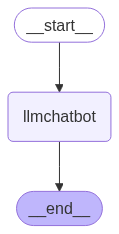

In [10]:
from IPython.display import Image, display
try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception :
    pass 

In [11]:
response = graph.invoke({"messages": ["Hello, how are you?"]})

In [12]:
response["messages"][-1].content

'I\'m just a language model, I don\'t have feelings or emotions like humans do, so I don\'t have good or bad days. I\'m always "on" and ready to help with any questions or tasks you may have! How can I assist you today?'

In [13]:
for event in graph.stream({"messages": ["Hello, how are you?"]}):
    for value in event.values():
        print(value["messages"][-1].content, end="", flush=True)

I'm just a language model, I don't have emotions or feelings like humans do, so I don't have good or bad days. I'm always "on" and ready to help with any questions or tasks you may have! How can I assist you today?

chatbot with tool:

In [14]:
from langchain_tavily import TavilySearch
tool = TavilySearch (max_results=2)
tool.invoke("What is the capital of France?")



{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is the Capital of France? - WorldAtlas',
   'url': 'https://www.worldatlas.com/articles/what-is-the-capital-of-france.html',
   'content': 'Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. Located in the north of Central France, the city is relatively flat with the highest point being 427 feet (which is Montmartre) above sea level while the lowest point is 115 feet above the sea level. With a GDP of approximately $850 billion, Paris is the country’s leader for economic activities. Tourists are attracted to Paris because of the rich history the city has including its monuments and sights. As the capital city of France, the city plays host to the national government of France. How Many Countries Are There In Africa? [x] Countries  All Countries',
   'score': 0.9170729,
   'ra

In [15]:
##custom functions
def multiply(a: int, b: int) -> int:
    """Return the product of two integers.
    Args:
        a (int): The first integer.
        b (int): The second integer.
    Returns:
        int: The product of the two integers.
    """
    return a * b

In [16]:
tools = [tool, multiply]

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x1113dddc0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11727aa90>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to

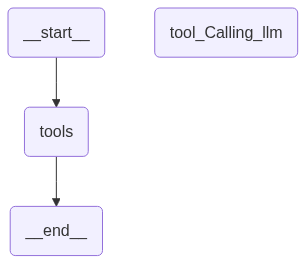

In [ ]:
#stategraph 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node definition
def tool_Calling_llm(state: State) -> State:
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
##graph builder
builder= StateGraph(State)
graph_builder = StateGraph(State)
builder.add_node("tool_Calling_llm",tool_Calling_llm)
builder.add_node("tools", ToolNode(tools))
##adding edges to the graph
builder.add_edge(START, "tools")
builder.add_conditional_edges("tool_Calling_llm",
                              #if the latest message(result) from assistant is a tool call -> tools_condition routes to tools
                              #if the latest message (result) from assistant is not a tool call -> tools_condition routes to END
                       tools_condition)
builder.add_edge("tools", END)
##compiling the graph
graph = builder.compile()
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response=graph.invoke({"messages": ["What is the capital of France?"]})

ValueError: No AIMessage found in input